# This Notebook has demo code for Interactive Segmentation


## The Arrangement  of notebook is :- 
### Step 1. Bounding Box Detection,  Step 2. Extract the Foreground Object , Step 3. Interactive segmentation 

## #1 Running information 
### 1. code by code -> (uncomment code block 1 to 7 and run code by code)
### 2. at once -> (comment code block 1 to 7 and run all code block at once)   
## #2 Path setting information 
### code block 0 is used to set all necessary path. 

### importing library

In [1]:
#importing library
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import glob
from matplotlib import cm

# Libraries
from PIL import Image as I
from sklearn.metrics.pairwise import cosine_similarity as cs
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from PIL import ImageOps, ImageDraw
from scipy.io import loadmat


import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
import os
from PIL import ImageFile
from pathlib import Path

### Function to display image

In [2]:
# function -> Display_image, compare_image,draw_boxes
def display_image(img,title='Image',fig_size =(15, 9),colour_cvt=True):
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    
    res = isinstance(img,str)
    if res:
        img = cv2.imread(img)
#     if len(img1.shape)==3:    
    if colour_cvt:
        img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
        

        
def compare_image(img1, img2,fig_size =(15, 9),colour_cvt=True):
    #fig,(ax1,ax2) = plt.subplots(1,2)
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    
    res = isinstance(img1, str)
    if res:
        img1= cv2.imread(img1)
    res =isinstance(img2,str)
    if res:
        img2= cv2.imread(img2)
    
    ax1 =fig.add_subplot(1,2,1)
#     if len(img1.shape)==3:
    if colour_cvt:
        img1= cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
        plt.imshow(img1)
    else:
        plt.imshow(img1, cmap='gray')
    ax1.set_title("original")
    ax1.axis('off')
       
    ax2 =fig.add_subplot(1,2,2)
#     if len(img1.shape)==3:
    if colour_cvt:
        img2= cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
        plt.imshow(img2)
    else:
        plt.imshow(img2,cmap='gray')
    ax2.set_title("result")
    ax2.axis('off')
   
  
def draw_boxes(imgs, boxes,title='bounding box'):
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(imgs, (x1, y1), (x2, y2), (0,255,0), 3)
    return imgs

### Code Block 0. Setting the path of the image

In [3]:
# setting path for images 
save_img_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/"
ref_img_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/Input Image.jpeg"
query_img_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg"
# # set TORCH_HOMe to folder where model is downloaded or want to downloads
os.environ['TORCH_HOME'] = 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/'

# step 1. Bounding Box Detection

## Helping Function 

In [4]:
def draw_rect(qi3, w, h, w2, h2):
    img2 = Image.fromarray(qi3)
    draw = ImageDraw.Draw(img2)
    draw.rectangle(((w, h), (w+w2, h+h2)), outline='Yellow', width=5)
    plt.imshow(np.array(img2))

In [5]:
def scale(ti, qi, bi_shape):
    h, w, _ = np.array(Image.open(qi)).shape
    h2, w2, _ = bi_shape
    h1, w1, _ = np.array(Image.open(ti)).shape
    return np.array(Image.open(ti).resize((int(w1*w/w2), int(h1*h/h2))))

In [6]:
# Function to get the embedding of the images

def get_vector(img):
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(to_tensor(img).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(torch.flatten(o.data, 1).squeeze())
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [7]:
# Function for Image embedding search

def slid_ims(qi,ti):
    h,w,_ = ti.shape
    ti_emb = get_vector(ti).reshape(1,-1)
    sl = [(cs(get_vector(qi[i:i+h, j:j+w]).reshape(1,-1), ti_emb),i,j)  for i in range(0,qi.shape[0]-h,10) for j in range(0,qi.shape[1]-w,10)]
    tl = [x[0] for x in sl]
    ma = np.argmax(tl)
    return sl[ma]

In [8]:
def slid_ensemble(qi, ti):
    h, w, _ = ti.shape
    s = np.linalg.svd(ti.transpose(2, 0, 1))[1].reshape(1, -1)
    sl1 = [(cs(np.linalg.svd(qi[i:i+h, j:j+w].transpose(2, 0, 1))[1].reshape(1, -1), s), i, j)
           for i in range(0, qi.shape[0]-h, 50) for j in range(0, qi.shape[1]-w, 50)]
    ti_emb = get_vector(ti).reshape(1, -1)
    sl2 = [(cs(get_vector(qi[i:i+h, j:j+w]).reshape(1, -1), ti_emb), i, j)
           for i in range(0, qi.shape[0]-h, 50) for j in range(0, qi.shape[1]-w, 50)]
    sl = [((x[0]+y[0])/2, x[1], x[2]) for x, y in zip(sl1, sl2)]
    tl = [x[0] for x in sl]
    ma = np.argmax(tl)
    return sl[ma]

In [9]:
def em(qi, h, w, tis, eps=10):
    l, b, _ = tis
    mh, mw, _ = qi.shape
    ph, pw = int(mh*.05), int(mw*.05)
    m = np.mean(qi[h:h+l, w:w+b])
    x1 = w
    x2 = w+b
    y1 = h
    y2 = h+l
    while x1 > pw:
        nw = x1-pw
        if (np.mean(qi[h:h + l, nw:w])-m) > eps:
            break
        x1 = nw
    while y1 > ph:
        nh = y1-ph
        if (np.mean(qi[nh:h, w:w+b])-m) > eps:
            break
        y1 = nh
    while x2+pw < mw-pw:
        nw = x2+pw
        if np.mean(qi[h:h + l, w:x2])-m > eps:
            break
        x2 = nw

    while y2+ph < mh-ph:
        nh = y2+ph
        if np.mean(qi[h+l:nh, w:w+b]) - m > eps:
            break
        y2 = nh

    return x1, y1, x2, y2

### Code Block 1.  for Model loading 

In [10]:
# Define & Download the pretrained model

model = models.resnet18(pretrained=True)

# Specify the layer embedding 
layer = model._modules.get('avgpool')

model.eval()

# convert into tensors
to_tensor = transforms.ToTensor()


### Code Block 2. getting boundning box,

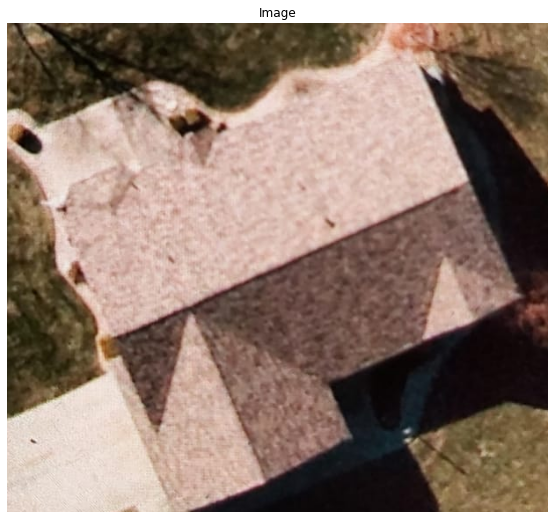

In [11]:
# Hummer annotation (bounding box )
ann ={"x":242,"y":367,"width":615,"height":557}  ## it will come from web. 

ref_img = np.array(I.open(ref_img_path))
snif_img= ref_img[ann['y']:ann['y']+ann['height'], ann['x']:ann['x']+ann['width']]
snif_img_path=save_img_path+'/snif_img.jpg'
plt.imsave(snif_img_path, snif_img)

# Show the target image
display_image(snif_img,colour_cvt=False)


### Code Block 3. searching the bounding box

searching similary image
91.0 %


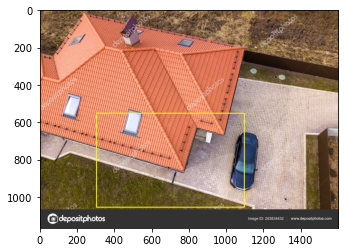

In [12]:
# # setting for the query images and performing the boundig box detection 
# query_img= np.array(I.open(query_img_path))

# terget_img = scale(snif_img_path, query_img_path,  np.array(Image.open(ref_img_path)).shape)

# print('searching similary image')
# sim, h4, w4 = slid_ensemble(query_img, terget_img)
# print(round(sim[0][0]*100), '%')
# draw_rect(query_img, w4,h4,terget_img.shape[1], terget_img.shape[0])

### Code Block 4. Drowing Bounding Box on Image 

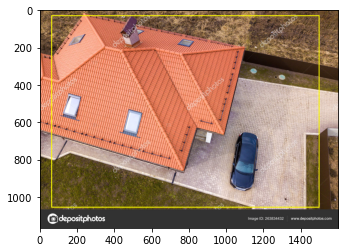

In [24]:
x1,y1,x2,y2 = em(query_img, h4,w4, terget_img.shape,eps=35)
bbox=(x1,y1,x2,y2)
draw_rect(query_img, x1,y1,x2-x1,y2-y1)

# Step 2. Extract the Foreground Object 

### Foreground Extraction Funciton

In [16]:
# Extract_forground -> function  Input image or image path
def Extract_forground(img,bbox):
    res = isinstance(img,str)
    if res:
        img= cv2.imread(img)
    # create a simple mask image similar 
    # to the loaded image, with the  
    # shape and return type 
    mask = np.zeros(img.shape[:2], np.uint8) 

    # specify the background and foreground model 
    # using numpy the array is constructed of 1 row 
    # and 65 columns, and all array elements are 0 
    # Data type for the array is np.float64 (default) 
    backgroundModel = np.zeros((1, 65), np.float64) 
    foregroundModel = np.zeros((1, 65), np.float64) 

    # define the Region of Interest (ROI) 
    # as the coordinates of the rectangle 
    # where the values are entered as 
    # (startingPoint_x, startingPoint_y, width, height) 
    # these coordinates are according to the input image 
    # it may vary for different images 
    # rectangle = (30, 20, 200, 400)
    # rectangle =(186, 34, 303, 304)
#     rectangle =(242,367,615,557)
    rectangle=bbox

    # apply the grabcut algorithm with appropriate 
    # values as parameters, number of iterations = 3  
    # cv2.GC_INIT_WITH_RECT is used because 
    # of the rectangle mode is used  
    cv2.grabCut(img, mask, rectangle,   
                backgroundModel, foregroundModel, 
                3, cv2.GC_INIT_WITH_RECT) 

    # In the new mask image, pixels will  
    # be marked with four flags  
    # four flags denote the background / foreground  
    # mask is changed, all the 0 and 2 pixels  
    # are converted to the background 
    # mask is changed, all the 1 and 3 pixels 
    # are now the part of the foreground 
    # the return type is also mentioned, 
    # this gives us the final mask 
    mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 

    # The final mask is multiplied with  
    # the input image to give the segmented image. 
    img = img * mask2[:, :, np.newaxis] 
    
    return img

### Code Block 5. Extract the detected bounding box 

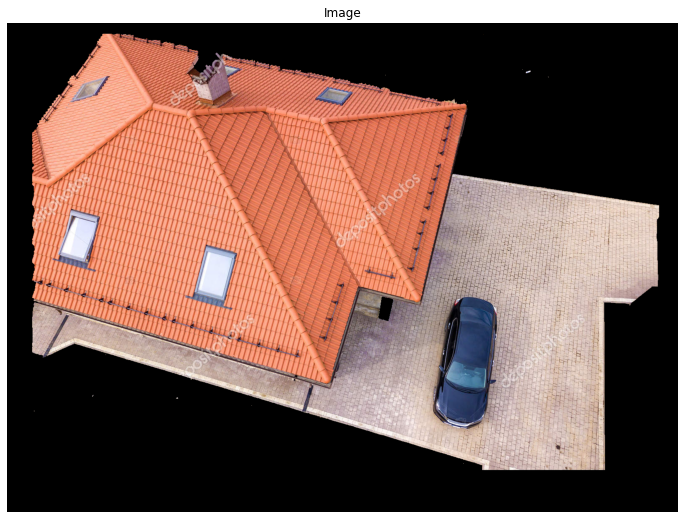

In [19]:
# display extracted image
img = Extract_forground(query_img_path,bbox)
display_image(img)

# Step 3. Watershed Alogorithm / Interactive segmentation

## Helping Function Declaration

In [51]:
img =cv2.imread("C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg")

In [52]:
#creating function for select color
def create_color(no_of_color=10):
    colors = []
    # One color for each single digit
    for i in range(no_of_color):
        x = np.array(cm.tab10(i))[:3]*255
        colors.append(x)
        
    return colors

In [ ]:
# mouse event 
def mouse_callback(event, x, y,flags, param):
    
    global marks_updated 

    if event == cv2.EVENT_LBUTTONDOWN:
        
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 5,(current_marker) , -1)
        
        # DISPLAY ON USER IMAGE
        cv2.circle(img_copy, (x, y), 5,colors[current_marker] , -1)
        marks_updated = True


### Code Block 6.  For setting default parameter 

In [53]:
#defoult setting change if you want 
width = 800 
height = 600
# Default settings
current_marker = 1
marks_updated = False
n_markers = 10
colors=create_color()

### Code Block 7. Interective Segmentation

In [56]:
cv2.namedWindow('Image')
cv2.setMouseCallback('Image',mouse_callback)

# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(width,height))
img_copy = img.copy()
img_seg_boundry = img.copy()
segments = np.zeros(img_copy.shape,dtype=np.uint8)
marker_image = np.zeros(img_copy.shape[:2],dtype=np.int32)

while True:
    cv2.imshow('Image',img_copy)
#     cv2.imshow('segmented_boundries',img_seg_boundry)
    cv2.imshow('Segments', segments)



    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break

    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        img_copy = img.copy()
        marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
        segments = np.zeros(img.shape,dtype=np.uint8)
        img_seg_boundry = img.copy()

    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit

        current_marker  = int(chr(k))


    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:

        marker_image_copy = marker_image.copy()
        cv2.watershed(img, marker_image_copy)

        segments = np.zeros(img.shape,dtype=np.uint8)

        contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # For every entry in contours
        for i in range(len(contours)):

            # last column in the array is -1 if an external contour (no contours inside of it)
            if hierarchy[0][i][3] == -1:

                # We can now draw the external contours from the list of contours
                cv2.drawContours(img_seg_boundry, contours, i, (0,0,255), 1)


        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]



            marks_updated = False

cv2.destroyAllWindows()

### 1 code by code run :- uncomment all code block form 1 to 7
### 2 whole at once :- run code block 8 only 

### Code Block 8. Interection 

loading model
extracting sniffing
searching similary image
91.0 %
extracting forground image 
interaction


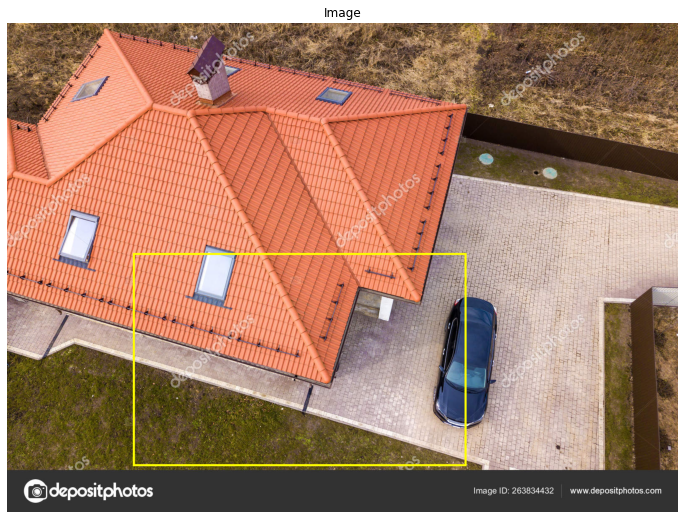

In [15]:
print('loading model')
# Define & Download the pretrained model
# local model loading 
model = models.resnet18(pretrained=True)

# Specify the layer embedding 
layer = model._modules.get('avgpool')

model.eval()
# convert into tensors
to_tensor = transforms.ToTensor()


print('extracting sniffing')
# Hummer annotation (bounding box )
ann ={"x":242,"y":367,"width":615,"height":557}

ref_img = np.array(I.open(ref_img_path))
snif_img= ref_img[ann['y']:ann['y']+ann['height'], ann['x']:ann['x']+ann['width']]
snif_img_path=save_img_path+'/snif_img.jpg'
plt.imsave(snif_img_path, snif_img)

# Show the target image
display_image(snif_img)


# setting for the query images and performing the boundig box detection 
query_img= np.array(I.open(query_img_path))

terget_img = scale(snif_img_path, query_img_path,  np.array(Image.open(ref_img_path)).shape)

print('searching similary image')
sim, h4, w4 = slid_ensemble(query_img, terget_img)
print(round(sim[0][0]*100), '%')
draw_rect(query_img, w4,h4,terget_img.shape[1], terget_img.shape[0])
x1,y1,x2,y2 = em(query_img, h4,w4, terget_img.shape,eps=35)
bbox=(x1,y1,x2,y2)

print('extracting forground image ')
# Extracting the foreground object for query image
img = Extract_forground(query_img, bbox)

print('interaction')
#default setting 
width = 800 
height = 600
# Default settings
current_marker = 1
marks_updated = False
n_markers = 10
colors=create_color()

# mouse event block 

cv2.namedWindow('Image')
cv2.setMouseCallback('Image',mouse_callback)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(width,height))
img_copy = img.copy()
img_seg_boundry = img.copy()
segments = np.zeros(img_copy.shape,dtype=np.uint8)
marker_image = np.zeros(img_copy.shape[:2],dtype=np.int32)

while True:
    cv2.imshow('Image',img_copy)
#     cv2.imshow('segmented_boundries',img_seg_boundry)
    cv2.imshow('Segments', segments)



    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break

    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        img_copy = img.copy()
        marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
        segments = np.zeros(img.shape,dtype=np.uint8)
        img_seg_boundry = img.copy()

    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit

        current_marker  = int(chr(k))


    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:

        marker_image_copy = marker_image.copy()
        cv2.watershed(img, marker_image_copy)

        segments = np.zeros(img.shape,dtype=np.uint8)

        contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # For every entry in contours
        for i in range(len(contours)):

            # last column in the array is -1 if an external contour (no contours inside of it)
            if hierarchy[0][i][3] == -1:

                # We can now draw the external contours from the list of contours
                cv2.drawContours(img_seg_boundry, contours, i, (0,0,255), 1)


        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]



            marks_updated = False

cv2.destroyAllWindows()

# Testing

In [42]:
# This Notebook has demo code for Interactive Segmentation

## The Arrangement  of notebook is :-
### Step 1. Bounding Box Detection,  Step 2. Extract the Foreground Object , Step 3. Interactive segmentation

## #1 Running information
### 1. code by code -> (uncomment code block 1 to 7 and run code by code)
### 2. at once -> (comment code block 1 to 7 and run all code block at once)
## #2 Path setting information
### code block 0 is used to set all necessary path.

### importing library

# importing library
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from matplotlib import cm

# Libraries
from PIL import Image as I
from sklearn.metrics.pairwise import cosine_similarity as cs
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from PIL import ImageOps, ImageDraw
from scipy.io import loadmat

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
import os
from PIL import ImageFile
from pathlib import Path

from datetime import datetime
from django.conf import settings
import pickle
import json

import logging
logger =logging.getLogger(__name__)


### Function to display image

# function -> Display_image, compare_image,draw_boxes
def display_image(img, title='Image', fig_size=(15, 9), colour_cvt=True):
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)

    res = isinstance(img, str)
    if res:
        img = cv2.imread(img)
    #     if len(img1.shape)==3:
    if colour_cvt:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')


def compare_image(img1, img2, fig_size=(15, 9), colour_cvt=True):
    # fig,(ax1,ax2) = plt.subplots(1,2)
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)

    res = isinstance(img1, str)
    if res:
        img1 = cv2.imread(img1)
    res = isinstance(img2, str)
    if res:
        img2 = cv2.imread(img2)

    ax1 = fig.add_subplot(1, 2, 1)
    #     if len(img1.shape)==3:
    if colour_cvt:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        plt.imshow(img1)
    else:
        plt.imshow(img1, cmap='gray')
    ax1.set_title("original")
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    #     if len(img1.shape)==3:
    if colour_cvt:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        plt.imshow(img2)
    else:
        plt.imshow(img2, cmap='gray')
    ax2.set_title("result")
    ax2.axis('off')


def draw_boxes(imgs, boxes, title='bounding box'):
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(imgs, (x1, y1), (x2, y2), (0, 255, 0), 3)
    return imgs


def save_data(data, path):
    with open(path, 'wb') as file:
        pickle.dump(data, file)


def load_data(path):
    with open(path, 'rb') as file:
        return pickle.load(file)


def draw_rect(qi3, w, h, w2, h2):
    img2 = Image.fromarray(qi3)
    draw = ImageDraw.Draw(img2)
    draw.rectangle(((w, h), (w + w2, h + h2)), outline='Yellow', width=5)
    plt.imshow(np.array(img2))


def save_bbox_img(img, w, h, w2, h2, path):
    img = cv2.rectangle(img, (w, h), (w + w2, h + h2), (0, 255, 0), 3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(path, img)


def scale(ti, qi, bi_shape):
    h, w, _ = np.array(Image.open(qi)).shape
    h2, w2, _ = bi_shape
    h1, w1, _ = np.array(Image.open(ti)).shape
    return np.array(Image.open(ti).resize((int(w1 * w / w2), int(h1 * h / h2))))


# ------------------------------------Step 1. Bounding Box Detection --------------------------------------------------

# Function to get the embedding of the images

def get_vector(img):
    # ---------------------------loadinng model------------------
    # os.environ['TORCH_HOME'] = 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/'
    # os.environ['TORCH_HOME'] = settings.MODEL_PATH  #todo uncomment 
    os.environ['TORCH_HOME'] =   MODEL_PATH
    # Define & Download the pretrained model
    model = models.resnet18(pretrained=True)
    # # Specify the layer embedding
    layer = model._modules.get('avgpool')

    model.eval()
    # convert into tensors
    to_tensor = transforms.ToTensor()
    # ---------------------------------------------------------
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(to_tensor(img).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)

    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(torch.flatten(o.data, 1).squeeze())

    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding


# Function for Image embedding search

def slid_ims(qi, ti):
    h, w, _ = ti.shape
    ti_emb = get_vector(ti).reshape(1, -1)
    sl = [(cs(get_vector(qi[i:i + h, j:j + w]).reshape(1, -1), ti_emb), i, j) for i in range(0, qi.shape[0] - h, 10) for
          j in range(0, qi.shape[1] - w, 10)]
    tl = [x[0] for x in sl]
    ma = np.argmax(tl)
    return sl[ma]


def slid_ensemble(qi, ti):
    h, w, _ = ti.shape
    s = np.linalg.svd(ti.transpose(2, 0, 1))[1].reshape(1, -1)
    sl1 = [(cs(np.linalg.svd(qi[i:i + h, j:j + w].transpose(2, 0, 1))[1].reshape(1, -1), s), i, j)
           for i in range(0, qi.shape[0] - h, 50) for j in range(0, qi.shape[1] - w, 50)]
    ti_emb = get_vector(ti).reshape(1, -1)
    sl2 = [(cs(get_vector(qi[i:i + h, j:j + w]).reshape(1, -1), ti_emb), i, j)
           for i in range(0, qi.shape[0] - h, 50) for j in range(0, qi.shape[1] - w, 50)]
    sl = [((x[0] + y[0]) / 2, x[1], x[2]) for x, y in zip(sl1, sl2)]
    tl = [x[0] for x in sl]
    ma = np.argmax(tl)
    return sl[ma]


def em(qi, h, w, tis, eps=10):
    l, b, _ = tis
    mh, mw, _ = qi.shape
    ph, pw = int(mh * .05), int(mw * .05)
    m = np.mean(qi[h:h + l, w:w + b])
    x1 = w
    x2 = w + b
    y1 = h
    y2 = h + l
    while x1 > pw:
        nw = x1 - pw
        if (np.mean(qi[h:h + l, nw:w]) - m) > eps:
            break
        x1 = nw
    while y1 > ph:
        nh = y1 - ph
        if (np.mean(qi[nh:h, w:w + b]) - m) > eps:
            break
        y1 = nh
    while x2 + pw < mw - pw:
        nw = x2 + pw
        if np.mean(qi[h:h + l, w:x2]) - m > eps:
            break
        x2 = nw

    while y2 + ph < mh - ph:
        nh = y2 + ph
        if np.mean(qi[h + l:nh, w:w + b]) - m > eps:
            break
        y2 = nh

    return x1, y1, x2, y2


def save_sniff_image(ref_img_path, ann):
    #     ann = {"x": 242, "y": 367, "width": 615, "height": 557}  ## it will come from web.

    ref_img = np.array(I.open(ref_img_path))
    snif_img = ref_img[ann['y']:ann['y'] + ann['height'], ann['x']:ann['x'] + ann['width']]
    file_name = ref_img_path.split('/')[-1]
    file_name = file_name.split('.')[0]
    # snif_img_path = settings.SAVE_PATH + '/snif_'+file_name+'.jpg' #todo uncomment
    snif_img_path = SAVE_PATH + '/snif_' + file_name + '.jpg'
    plt.imsave(snif_img_path, snif_img)
    print('snif_img_path : {}'.format( snif_img_path))
    return snif_img_path


def get_searched_bbox(query_img_path, snif_img_path, ref_img_path, eps_list):
    # setting for the query images and performing the boundig box detection
    query_img = np.array(I.open(query_img_path))

    terget_img = scale(snif_img_path, query_img_path, np.array(Image.open(ref_img_path)).shape)

    print('searching similary image')
    sim, h4, w4 = slid_ensemble(query_img, terget_img)
    print('confident score : {} %'.format(round(sim[0][0] * 100)))
    # draw_rect(query_img, w4, h4, terget_img.shape[1], terget_img.shape[0])
    ### Code Block 4. Drowing Bounding Box on Image
    print('saving images ...')
    bbox_list = []
    box_img_path_list = []
    #     box_img_list=[]
    file_name = query_img_path.split('/')[-1]
    file_name = file_name.split('.')[0]
    for idx, eps in enumerate(eps_list):
        x1, y1, x2, y2 = em(query_img, h4, w4, terget_img.shape, eps=35)
        bbox = (x1, y1, x2, y2)
        bbox_list.append(bbox)
        # box_save_path = settings.SAVE_PATH+file_name+'_eps_'+str(eps)+'.jpg' #todo uncomment
        box_save_path = SAVE_PATH + file_name + '_eps_' + str(eps) + '.jpg'
        save_bbox_img(query_img, x1, y1, x2 - x1, y2 - y1, box_save_path)
        box_img_path_list.append(box_save_path)
    #         draw_rect(query_img, x1, y1, x2 - x1, y2 - y1)
    return bbox_list, box_img_path_list


# Step 2. Extract the Foreground Object


def get_bounding_box(query_img_path, ref_img_path, bbox):
    snif_img_path = save_sniff_image(ref_img_path, bbox)
    eps_list = [20, 35, 50, 65]
    search_start_time = datetime.now()
    #     bbox_list,box_img_path_list = get_searched_bbox(query_img_path,snif_img_path,ref_img_path,eps_list )#todo uncomment
    bbox_list, box_img_path_list = get_searched_bbox(snif_img_path, snif_img_path, ref_img_path, eps_list)
    print('Time elapsed in searching (hh:mm:ss.ms):  {}'.format(datetime.now() - search_start_time))

    # save_data([bbox_list,box_img_path_list,eps_list], settings.SAVE_PATH+'box_path_eps_data.pkl')#todo uncomment
    # print('data is saved : {}'.format(settings.SAVE_PATH+'box_path_eps_data.pkl'))#todo uncomment

    save_data([bbox_list, box_img_path_list, eps_list], SAVE_PATH + 'box_path_eps_data.pkl')
    print('data is saved : ', SAVE_PATH + 'box_path_eps_data.pkl')
    bbox_img_path_json = {}
    for idx, eps in enumerate(eps_list):
        bbox_img_path_json[str(eps)] = box_img_path_list[idx]
    return json.dumps(bbox_img_path_json)

# ------------------------------------Step 2. Extract the Foreground Object --------------------------------------------------
### Foreground Extraction Funciton

# Extract_forground -> function  Input image or image path
def Extract_forground(img, bbox):
    res = isinstance(img, str)
    if res:
        img = cv2.imread(img)
    # create a simple mask image similar
    # to the loaded image, with the
    # shape and return type
    mask = np.zeros(img.shape[:2], np.uint8)

    # specify the background and foreground model
    # using numpy the array is constructed of 1 row
    # and 65 columns, and all array elements are 0
    # Data type for the array is np.float64 (default)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)

    # define the Region of Interest (ROI)
    # as the coordinates of the rectangle
    # where the values are entered as
    # (startingPoint_x, startingPoint_y, width, height)
    # these coordinates are according to the input image
    # it may vary for different images
    # rectangle = (30, 20, 200, 400)
    # rectangle =(186, 34, 303, 304)
    #     rectangle =(242,367,615,557)
    rectangle = bbox

    # apply the grabcut algorithm with appropriate
    # values as parameters, number of iterations = 3
    # cv2.GC_INIT_WITH_RECT is used because
    # of the rectangle mode is used
    cv2.grabCut(img, mask, rectangle,
                backgroundModel, foregroundModel,
                3, cv2.GC_INIT_WITH_RECT)

    # In the new mask image, pixels will
    # be marked with four flags
    # four flags denote the background / foreground
    # mask is changed, all the 0 and 2 pixels
    # are converted to the background
    # mask is changed, all the 1 and 3 pixels
    # are now the part of the foreground
    # the return type is also mentioned,
    # this gives us the final mask
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # The final mask is multiplied with
    # the input image to give the segmented image.
    img = img * mask2[:, :, np.newaxis]

    return img


def save_extracted_image(query_img_path, eps):
    # data =load_data(settings.SAVE_PATH+'box_path_eps_data.pkl')#todo uncomment
    data = load_data(SAVE_PATH + 'box_path_eps_data.pkl')
    bbox_list = data[0]
    box_img_path_list = data[1]
    eps_list = data[2]
    idx = eps_list.index(int(eps))
    print('eps : {} at index :{}'.format(eps, idx))
    img = Extract_forground(query_img_path, bbox_list[idx])
    file_name = query_img_path.split('/')[-1]
    file_name = file_name.split('.')[0]
    # save_path = settings.SAVE_PATH +'foreground_'+file_name+'.jpg' #todo uncomment
    save_path = SAVE_PATH + 'foreground_' + file_name + '.jpg'
    #     img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, img)
    extracted_fg_img_path={}
    extracted_fg_img_path['extracted_fg_img_path']=save_path
    return json.dumps(extracted_fg_img_path)


# Step 1. Bounding Box Detection,   ,

# ------------------------------------Step 3. Interactive segmentation --------------------------------------------------

# creating function for select color
def create_color(no_of_color=10):
    colors = []
    # One color for each single digit
    for i in range(no_of_color):
        x = np.array(cm.tab10(i))[:3] * 255
        colors.append(x)

    return colors


# mouse event
def mouse_callback(event, x, y, flags, param):
    global marks_updated, current_marker, colors, marker_image, img_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 5, (current_marker), -1)

        # DISPLAY ON USER IMAGE
        cv2.circle(img_copy, (x, y), 5, colors[current_marker], -1)
        marks_updated = True


def interact_with_img(img):
    # defoult setting change if you want
    width = 800
    height = 600
    # Default settings
    current_marker = 1
    marks_updated = False
    n_markers = 10
    colors = create_color()

    ### Code Block 7. Interective Segmentation

    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', mouse_callback)

    res = isinstance(img, str)
    if res:
        img = cv2.imread(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img_copy = img.copy()
    img_seg_boundry = img.copy()
    segments = np.zeros(img_copy.shape, dtype=np.uint8)
    marker_image = np.zeros(img_copy.shape[:2], dtype=np.int32)

    while True:
        cv2.imshow('Image', img_copy)
        #     cv2.imshow('segmented_boundries',img_seg_boundry)
        cv2.imshow('Segments', segments)

        # Close everything if Esc is pressed
        k = cv2.waitKey(1)

        if k == 27:
            break

        # Clear all colors and start over if 'c' is pressed
        elif k == ord('c'):
            img_copy = img.copy()
            marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
            segments = np.zeros(img.shape, dtype=np.uint8)
            img_seg_boundry = img.copy()

        # If a number 0-9 is chosen index the color
        elif k > 0 and chr(k).isdigit():
            # chr converts to printable digit

            current_marker = int(chr(k))

        # If we clicked somewhere, call the watershed algorithm on our chosen markers
        if marks_updated:

            marker_image_copy = marker_image.copy()
            cv2.watershed(img, marker_image_copy)

            segments = np.zeros(img.shape, dtype=np.uint8)

            contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

            # For every entry in contours
            for i in range(len(contours)):

                # last column in the array is -1 if an external contour (no contours inside of it)
                if hierarchy[0][i][3] == -1:
                    # We can now draw the external contours from the list of contours
                    cv2.drawContours(img_seg_boundry, contours, i, (0, 0, 255), 1)

            for color_ind in range(n_markers):
                segments[marker_image_copy == (color_ind)] = colors[color_ind]

                marks_updated = False

    cv2.destroyAllWindows()


In [43]:
data={ 'save_img_path' : "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/",
'ref_img_path' : "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/Input Image.jpeg",
'query_img_path' : "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg",
'TORCH_HOME': 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/',
'bbox' : {"x": 242, "y": 367, "width": 615, "height": 557} }

query_img_path = data['query_img_path']
ref_img_path=data['ref_img_path']
bbox=data['bbox']
SAVE_PATH=data['save_img_path']
MODEL_PATH=data['TORCH_HOME']
# settings=settings.configure()

In [45]:
import traceback
try:
#     bbox_img_path_json= get_bounding_box(query_img_path, ref_img_path, bbox)
    print('bbox_img_path_json : {}'.format( bbox_img_path_json))
    eps=35
#     extracted_fg_img_path = save_extracted_image(query_img_path, eps)
    print('extracted_fg_img_path : {}'.format( extracted_fg_img_path))
    interact_with_img(save_path)
except Exception as e :
    print(e)
    print('\n\n\n\n')
    print(traceback.format_exc())

bbox_img_path_json : {"20": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/snif_Input Image_eps_20.jpg", "35": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/snif_Input Image_eps_35.jpg", "50": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/snif_Input Image_eps_50.jpg", "65": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/snif_Input Image_eps_65.jpg"}
extracted_fg_img_path : {"extracted_fg_img_path": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/foreground_image_17_top.jpg"}


In [ ]:
import traceback
try:
#     bbox_img_path_json= get_bounding_box(query_img_path, ref_img_path, bbox)
    print('bbox_img_path_json : {}'.format( bbox_img_path_json))
    eps=35
#     extracted_fg_img_path = save_extracted_image(query_img_path, eps)
    print('extracted_fg_img_path : {}'.format( extracted_fg_img_path))
    interact_with_img(save_path)
except Exception as e :
    print(e)
    print('\n\n\n\n')
    print(traceback.format_exc())

In [25]:
import traceback
try:
    get_bounding_box(query_img_path, ref_img_path, bbox)
    eps=35
    save_path =save_extracted_image(query_img_path,eps)
    print(save_path)
    interact_with_img(save_path)
except Exception as e :
    print(e)
    print('\n\n\n\n')
    print(traceback.format_exc())

snif_img_path :  C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data//snif_Input Image.jpg
searching similary image
93.0 %
saving images ...
Time elapsed in searching (hh:mm:ss.ms):  0:01:18.453967
data is saved :  C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/box_path_eps_data.pkl
eps : 35 at index :1
C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/foreground_image_17_top.jpg


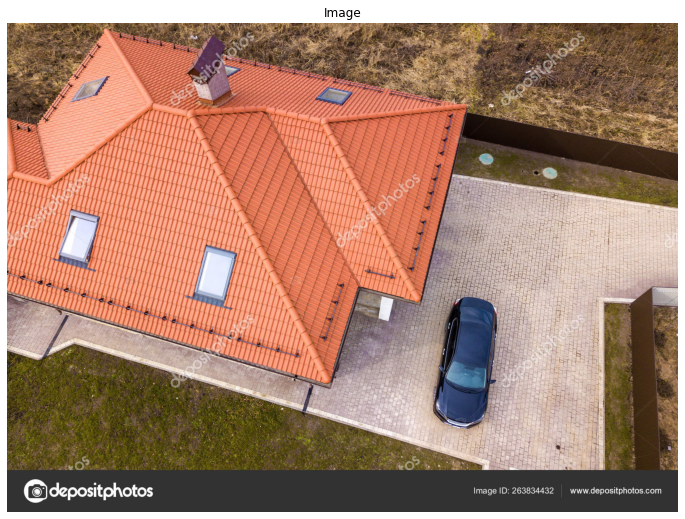

In [66]:
display_image(query_img_path)

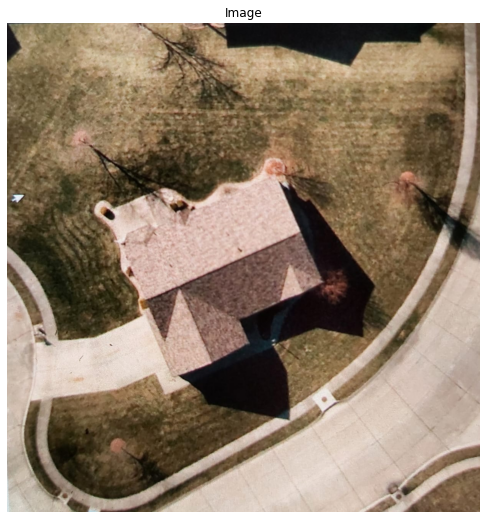

In [67]:
display_image(ref_img_path)

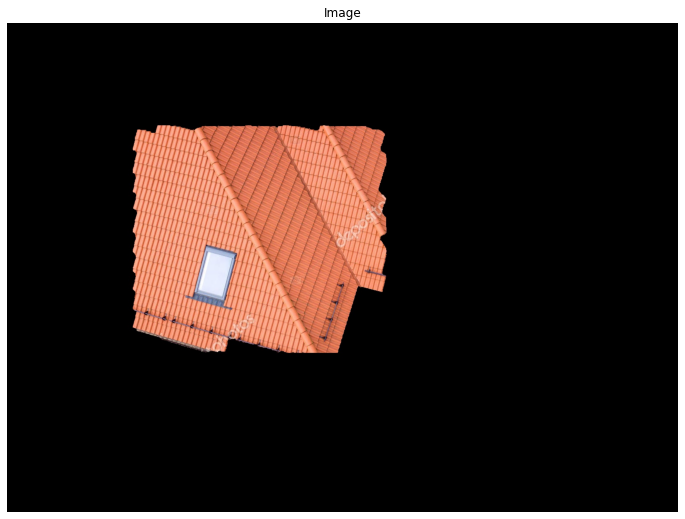

In [68]:
display_image(save_path)

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot([1,2,3])
plt.savefig(SAVE_PATH+'test_123.jpg')

In [32]:
import json
d={'ref_img_path' : "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/Input Image.jpeg",
'query_img_path' : "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg",
'bbox' : {"x": 242, "y": 367, "width": 615, "height": 557} }

json.dumps(d)

'{"ref_img_path": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/Input Image.jpeg", "query_img_path": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg", "bbox": {"x": 242, "y": 367, "width": 615, "height": 557}}'

In [ ]:
query_img_path = request.data['query_img_path']
        eps=request.data['eps']

In [33]:
d={'query_img_path' : "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg",
'eps' : '35' }

json.dumps(d)

'{"query_img_path": "C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg", "eps": "35"}'

In [76]:

# creating function for select color
def create_color(no_of_color=10):
    colors = []
    # One color for each single digit
    for i in range(no_of_color):
        x = np.array(cm.tab10(i))[:3] * 255
        colors.append(x)

    return colors


# mouse event
def mouse_callback(event, x, y, flags, param):
#     global marks_updated, current_marker, colors, marker_image, img_copy
    marks_updated=param[0]
    current_marker=param[1]
    colors=param[2]
    marker_image = param[3]
    img_copy = param[4]
    if event == cv2.EVENT_LBUTTONDOWN:
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 5, (current_marker), -1)

        # DISPLAY ON USER IMAGE
        cv2.circle(img_copy, (x, y), 5, colors[current_marker], -1)
        marks_updated = True


def interact_with_img(img):
    # defoult setting change if you want
    width = 800
    height = 600
    # Default settings
    current_marker = 1
    marks_updated = False
    n_markers = 10
    colors = create_color()

    ### Code Block 7. Interective Segmentation
    

    res = isinstance(img, str)
    if res:
        img = cv2.imread(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img_copy = img.copy()
    img_seg_boundry = img.copy()
    segments = np.zeros(img_copy.shape, dtype=np.uint8)
    marker_image = np.zeros(img_copy.shape[:2], dtype=np.int32)
    param=[marks_updated, current_marker, colors, marker_image, img_copy]
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', mouse_callback, param)
    while True:
        cv2.imshow('Image', img_copy)
        #     cv2.imshow('segmented_boundries',img_seg_boundry)
        cv2.imshow('Segments', segments)

        # Close everything if Esc is pressed
        k = cv2.waitKey(1)

        if k == 27:
            break

        # Clear all colors and start over if 'c' is pressed
        elif k == ord('c'):
            img_copy = img.copy()
            marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
            segments = np.zeros(img.shape, dtype=np.uint8)
            img_seg_boundry = img.copy()

        # If a number 0-9 is chosen index the color
        elif k > 0 and chr(k).isdigit():
            # chr converts to printable digit

            current_marker = int(chr(k))

        # If we clicked somewhere, call the watershed algorithm on our chosen markers
        if marks_updated:

            marker_image_copy = marker_image.copy()
            cv2.watershed(img, marker_image_copy)

            segments = np.zeros(img.shape, dtype=np.uint8)

            contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

            # For every entry in contours
            for i in range(len(contours)):

                # last column in the array is -1 if an external contour (no contours inside of it)
                if hierarchy[0][i][3] == -1:
                    # We can now draw the external contours from the list of contours
                    cv2.drawContours(img_seg_boundry, contours, i, (0, 0, 255), 1)

            for color_ind in range(n_markers):
                segments[marker_image_copy == (color_ind)] = colors[color_ind]

                marks_updated = False

    cv2.destroyAllWindows()


In [ ]:
interact_with_img("C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg")

In [11]:
class Interect_with_mouse():
    
    def __init__(self,path,width=800,height=600,current_marker=1,marks_updated=False,n_markers=10):
        self.img_path=path
        self.param=[]
            # defoult setting change if you want
        self.width = width
        self.height = height
        # Default settings
        self.current_marker = current_marker
        self.marks_updated = marks_updated
        self.n_markers = n_markers
        
        self.colors=None
        self.marker_image=None
        self.img_copy=None
        self.img=None
    def create_color(self, no_of_color=10):
        colors = []
        # One color for each single digit
        for i in range(no_of_color):
            x = np.array(cm.tab10(i))[:3] * 255
            colors.append(x)

        return colors

    def mouse_callback(self,event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # TRACKING FOR MARKERS
            cv2.circle(self.marker_image, (x, y), 5, (self.current_marker), -1)

            # DISPLAY ON USER IMAGE
            cv2.circle(self.img_copy, (x, y), 5, self.colors[self.current_marker], -1)
            self.marks_updated = True
        
    def interact_with_img(self):
#     # defoult setting change if you want
#     width = 800
#     height = 600
#     # Default settings
#     current_marker = 1
#     marks_updated = False
#     n_markers = 10
        self.colors = self.create_color(self.n_markers)


        self.img = cv2.imread(self.img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.img = cv2.resize(self.img, (self.width, self.height))
        self.img_copy = self.img.copy()
        img_seg_boundry = self.img.copy()
        segments = np.zeros(self.img_copy.shape, dtype=np.uint8)
        self.marker_image = np.zeros(self.img_copy.shape[:2], dtype=np.int32)

        cv2.namedWindow('Image')
        cv2.setMouseCallback('Image', self.mouse_callback)
        while True:
            cv2.imshow('Image', self.img_copy)
            #     cv2.imshow('segmented_boundries',img_seg_boundry)
            cv2.imshow('Segments', segments)

            # Close everything if Esc is pressed
            k = cv2.waitKey(1)

            if k == 27:
                break

            # Clear all colors and start over if 'c' is pressed
            elif k == ord('c'):
                self.img_copy = self.img.copy()
                self.marker_image = np.zeros(self.img.shape[0:2], dtype=np.int32)
                segments = np.zeros(self.img.shape, dtype=np.uint8)
                img_seg_boundry = self.img.copy()

            # If a number 0-9 is chosen index the color
            elif k > 0 and chr(k).isdigit():
                # chr converts to printable digit

                self.current_marker = int(chr(k))

            # If we clicked somewhere, call the watershed algorithm on our chosen markers
            if self.marks_updated:

                marker_image_copy = self.marker_image.copy()
                cv2.watershed(self.img, marker_image_copy)

                segments = np.zeros(self.img.shape, dtype=np.uint8)

                contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

                # For every entry in contours
                for i in range(len(contours)):

                    # last column in the array is -1 if an external contour (no contours inside of it)
                    if hierarchy[0][i][3] == -1:
                        # We can now draw the external contours from the list of contours
                        cv2.drawContours(img_seg_boundry, contours, i, (0, 0, 255), 1)

                for color_ind in range(self.n_markers):
                    segments[marker_image_copy == (color_ind)] = self.colors[color_ind]

                    marks_updated = False
            
        cv2.destroyAllWindows()

    
        

In [12]:
inter=Interect_with_mouse("C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/image_17_top.jpg")

In [13]:
inter.interact_with_img()

In [1]:

### importing library

# importing library
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from matplotlib import cm

# Libraries
from PIL import Image as I
from sklearn.metrics.pairwise import cosine_similarity as cs
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from PIL import ImageOps, ImageDraw
from scipy.io import loadmat

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
import os
from PIL import ImageFile
from pathlib import Path

from datetime import datetime
from django.conf import settings
import pickle
import json

import logging
logger =logging.getLogger(__name__)
